# Hierarchical Clustering Build Structural Topic Model on NEH Grant Products

<b>Author:</b> Jaren Haber, PhD <br>
<b>Date</b>: October 27, 2023 <br>
<b>Description</b>: Estimates hierarchical clustering model, analyzes results, and generates visualizations. <br>
<b>Sources</b>: Code snippets and inspiration borrowed from [my team's work here](https://github.com/h2researchgroup/embeddings/blob/main/clustering/hierarchical_by_decade.ipynb) and [this template viz code from scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py) <br>
<b>Required packages</b> (to install): TBD <br>

## Initialize

In [35]:
# Import generic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from collections import Counter
from tqdm import tqdm
import joblib
import csv

# Import packages for modeling
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler # for normalizing features

# Import local function(s)
from utils import get_unzip

## Import data from web

In [2]:
# Define URL of zipped file
data_url = 'https://archive.ics.uci.edu/static/public/186/wine+quality.zip'
fpath = '../data'

# Download zipped file and extract
get_unzip(data_url, fpath)

## Prepare data

### Combine data for both wine types

In [3]:
# Define file suffixes for wine types
wine_types = [
    'red', 
    'white'
]

In [4]:
## Load each wine type and combine into one DataFrame
dfs = [] # Create empty list for both wine DataFrames

# Loop over wine types and add to list of DFs
for color in wine_types: 
    wine_df = pd.read_csv(join('../data/', f'winequality-{color}.csv'), low_memory=False, sep=";")
    wine_df['wine type'] = color # add column for wine type
    dfs.append(wine_df)
    
df = pd.concat(dfs) # Combine DFs into one

In [5]:
# Inspect full data
print("Count of rows, columns in full data:", df.shape)
print(f"These are the {str(len(df.columns))} column names:")
print(", ".join([col for col in df.columns]))
print()
df.sample(10) # Show 10 random rows

Count of rows, columns in full data: (6497, 13)
These are the 13 column names:
fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality, wine type



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine type
4752,5.1,0.25,0.36,1.3,0.035,40.0,78.0,0.98910,3.23,0.64,12.1,7,white
3462,6.8,0.17,0.34,2.0,0.040,38.0,111.0,0.99000,3.24,0.45,12.9,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,white
93,6.9,0.21,0.33,1.8,0.034,48.0,136.0,0.98990,3.25,0.41,12.6,7,white
1715,6.5,0.18,0.34,1.6,0.040,43.0,148.0,0.99120,3.32,0.59,11.5,8,white
4200,8.0,0.24,0.33,1.2,0.044,28.0,101.0,0.99035,3.03,0.43,12.5,6,white
1744,6.6,0.22,0.58,1.1,0.133,52.0,136.0,0.99320,3.10,0.30,9.1,5,white
3108,7.6,0.35,0.46,14.7,0.047,33.0,151.0,0.99709,3.03,0.53,10.3,5,white
2688,7.2,0.19,0.27,11.2,0.061,46.0,149.0,0.99772,2.99,0.59,9.3,6,white
447,6.5,0.41,0.24,14.0,0.048,24.0,113.0,0.99820,3.44,0.53,9.8,6,white


### Create arrays for features (X) and outcome variable (y)

In [50]:
######################################################
# Prepare training and validation data
######################################################

# Separate training and final validation data set. First remove class
# label from data (X). Setup target class (Y)
# Then make the test/validation set 20% of the entire
# set of labeled data (X_test, Y_test)

test_size = 0.2
seed = 3

# set outcome/response variable
y = df.quality
#y = valueArray[:,1]
y = y.astype('float')

# set features/predictors and normalize so they share a standard 0-1 scale
features = df[[col for col in df.columns if col!='quality']] 
features['red'] = features['wine type'].map({'red':1, 'white':0})
features.drop(columns=['wine type'], inplace=True)

scaler = MinMaxScaler()
scaler.fit(features)
X = scaler.transform(features)    

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=test_size, 
    random_state=seed
)

print(f'y_train Distribution: {Counter(y_train).most_common()}')
pd.DataFrame(X).head()

y_train Distribution: [(6.0, 2272), (5.0, 1704), (7.0, 865), (4.0, 174), (8.0, 154), (3.0, 25), (9.0, 3)]


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.297521,0.413333,0.000000,0.019939,0.111296,0.034722,0.064516,0.206092,0.612403,0.191011,0.202899,1.0
1,0.330579,0.533333,0.000000,0.030675,0.147841,0.083333,0.140553,0.186813,0.372093,0.258427,0.260870,1.0
2,0.330579,0.453333,0.024096,0.026074,0.137874,0.048611,0.110599,0.190669,0.418605,0.241573,0.260870,1.0
3,0.611570,0.133333,0.337349,0.019939,0.109635,0.055556,0.124424,0.209948,0.341085,0.202247,0.260870,1.0
4,0.297521,0.413333,0.000000,0.019939,0.111296,0.034722,0.064516,0.206092,0.612403,0.191011,0.202899,1.0


In [27]:
######################################################
# Setup 10-fold cross validation for model evaluation
######################################################

# Define test options for k-fold CV
num_folds = 10 
seed = 3
scoring='f1_weighted' # set scoring metric (not used here)

def show_kfold_output(models,  
                      X, 
                      Y, 
                      df, 
                      text_col, 
                      vectorizer, 
                      num_folds = num_folds, 
                      random_state = seed, 
                      shuffle = True):
    '''
    Estimates the accuracy of different model algorithms, adds results to a results array and returns.
    Prints the accuracy results: averages and std.
    Uses cross_val_predict, which unlike cross_val_score cannot define scoring option/evaluation metric.
    
    Args:
        models: list of (name, model) tuples
        X: predictors
        Y: outcomes
        num_folds: Split data randomly into num_folds parts: (num_folds-1) for training, 1 for scoring
        random_state: seed
        shuffle: 
    
    Returns:
        results: list of model results
        names: list of model names (matches results)
        
    Source: 
        https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn
    '''
    
    global num_folds, seed # Access parameters outside function domain space
    
    results = []
    names = []
    
    for name, model in models:
        # Print name of model
        print(f'{name}:')
        print()
        
        # Setup model options
        kfold = KFold(
            n_splits=num_folds, 
            random_state=seed, 
            shuffle=True)
        
        # Get kfold results
        cv_results = cross_val_predict(
            model.fit(X, Y), 
            X, 
            Y, 
            cv=kfold, 
            #scoring=scoring, 
            n_jobs=-1) # use all cores = faster
        
        # Add results and name of each algorithm to the model array
        results.append(cv_results)
        names.append(name)
        
        # Validation step: Predict class probabilities in labeled data, compare to actual labels
        try:
            tqdm.pandas(desc="Computing predictions")
            df[['prediction', 'prediction_prob_yes', 'prediction_prob_no']] = df[text_col].progress_apply(
            lambda text: pd.Series(compute_predictions([sent for sent in sent_tokenize(text)], vectorizer, model)))
            print("Distribution of predicted labels:\n", df['prediction'].value_counts()) # show predicted distribution, compare to labeled distribution
            print()
        except: 
            pass
        
        # Print results
        print(f'Mean (std):\t {round(cv_results.mean(),4)} ({round(cv_results.std(),4)})')
        print(f'Accuracy:\t', {round(accuracy_score(Y, cv_results)), 4})
        print()
        print('Confusion matrix:\n', confusion_matrix(Y, cv_results))
        print()
        print('Report:\n', classification_report(Y, cv_results))
        print()
        
    # Return arrays
    return results, names

## Evaluate data quality

### Examine missingness

In [6]:
# Check whether any column has a missing value anywhere
df.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
wine type               False
dtype: bool

### Examine distributions

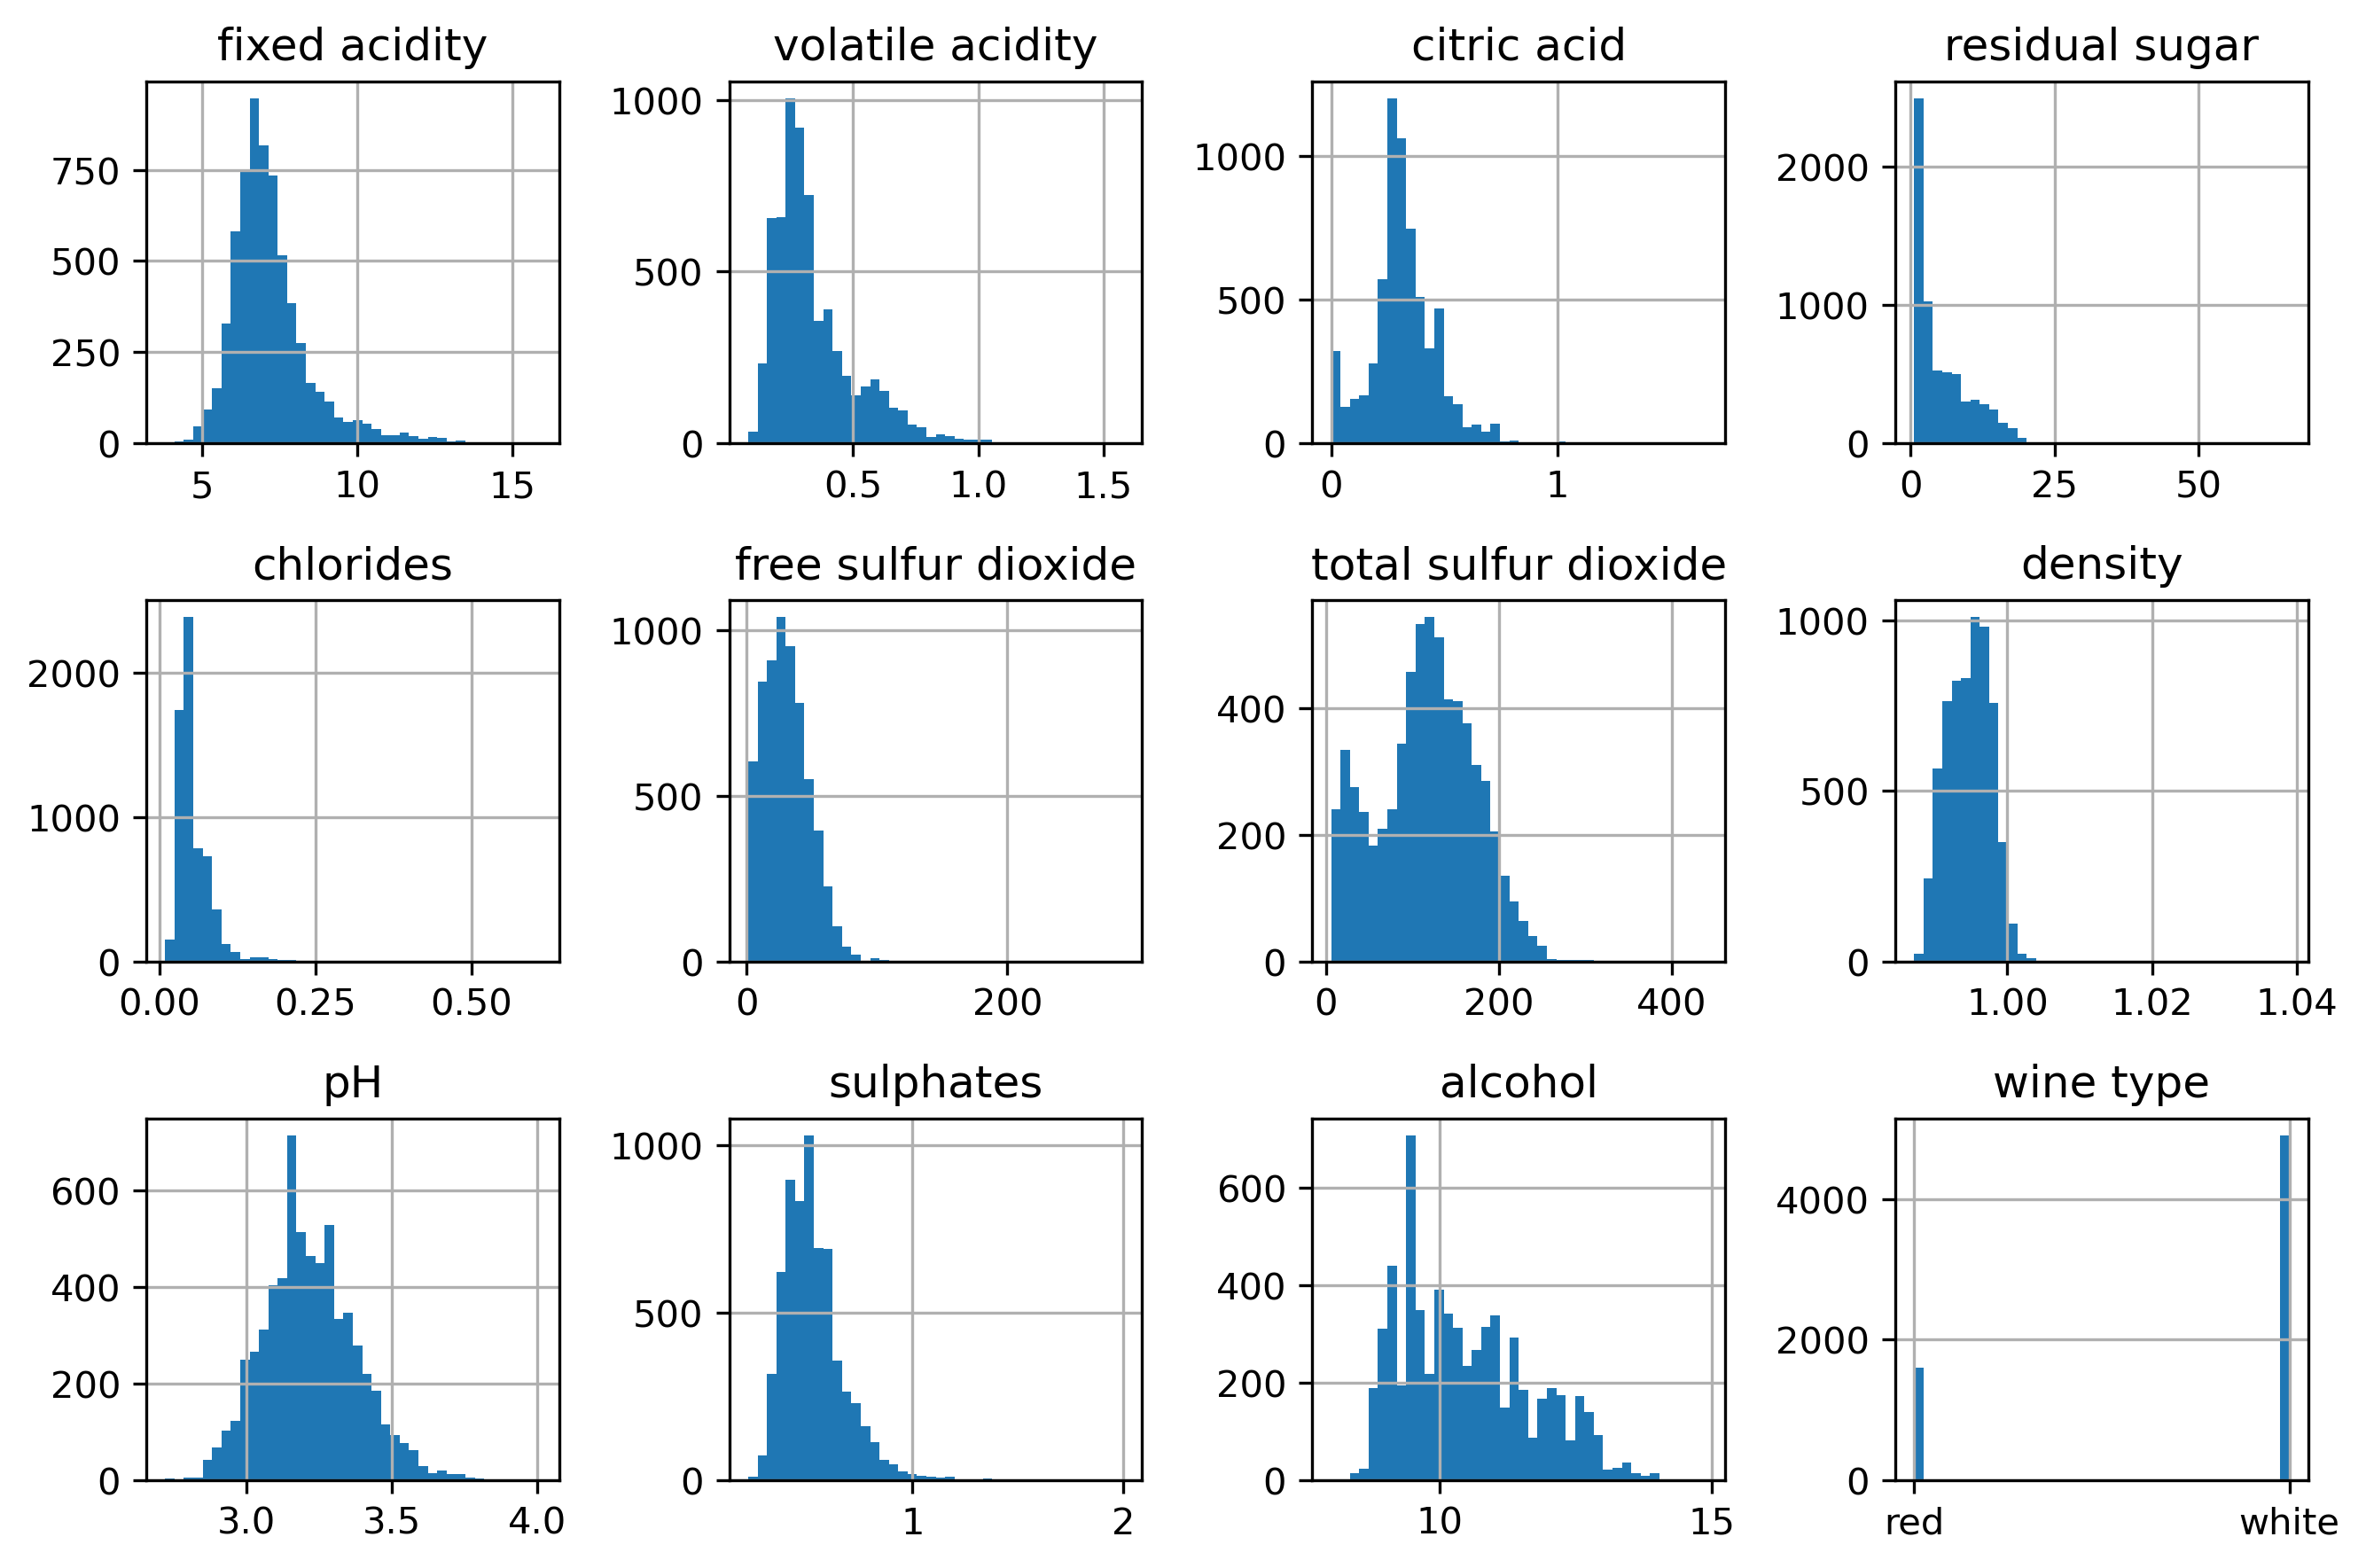

In [7]:
# Check shape of each input variable's distribution
fig = plt.figure(dpi=300, figsize = (9,6)) # initialize grid of histograms

for i, var_name in enumerate([col for col in df.columns if col!='quality']):
    ax = fig.add_subplot(3, 4, i+1)
    df[var_name].hist(bins=40, ax=ax)
    ax.set_title(var_name)

fig.tight_layout()  # improves appearance
plt.show()

In [29]:
print(f'Numerical distribution of wine quality: {Counter(df.quality).most_common()}')

Distribution of wine quality: [(6, 2836), (5, 2138), (7, 1079), (4, 216), (8, 193), (3, 30), (9, 5)]


<AxesSubplot:>

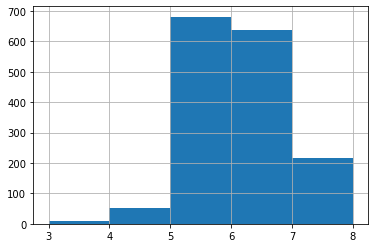

In [16]:
# Check shape of output variable's distribution for each wine type
qual_range = df[df['wine type']=='red'].quality.max() - df[df['wine type']=='red'].quality.min()
df[df['wine type']=='red'].quality.hist(bins=qual_range)

<AxesSubplot:>

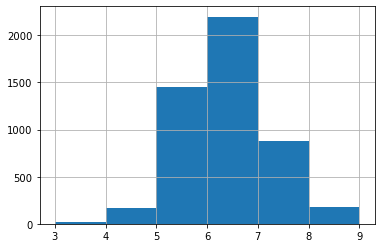

In [17]:
qual_range = df[df['wine type']=='white'].quality.max() - df[df['wine type']=='white'].quality.min()
df[df['wine type']=='white'].quality.hist(bins=qual_range)

In [26]:
print('Attributes of quality for each wine type:')
df.groupby('wine type').agg({'quality':['min', np.mean, np.median, 'max']})

Attributes of quality for each wine type:


quality                     
              min      mean median max
wine type                             
red             3  5.636023    6.0   8
white           3  5.877909    6.0   9

<b>Interpretation:</b> No missing values, lots of normal distributions, average quality is higher for white wine

## Estimate clustering model

In [ ]:
def plot_dendrogram(model, 
                    linkage='average',
                    figsize=(20,10), 
                    color_labels=None, 
                    yrange=None, 
                    xrange=None,
                    title="Dendrogram", 
                    save_plot=None, 
                    **kwargs):
    
    '''Creates linkage matrix using word embedding model and then plots the dendrogram.
    
    Params:
        model (obj): clustering model from scikit-learn
        figsize (tuple): height x width of dendrogram
        save_plot (boolean or str): whether or not to save dendrogram to disk, True or False; if True, the filename for figure
        
    Returns: 
        Dendrogram via Scipy saved to disk
    '''

    # create the counts of samples under each node
    fig = plt.figure(figsize=figsize)
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    children, distances, counts = model.children_, model.distances_, np.array(counts)

    linkage_matrix = np.column_stack(
        [children, distances, counts]
    ).astype(float)
    
    cluster_threshold = 0.7*max(linkage_matrix[:,2])
    print(f'cluster threshold: {cluster_threshold}')

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    ax = plt.gca()
    
    # Customize plot layout by dendrogram orientation
    if orientation == 'top': # 'top' orientation
        ax.set_ylim(yrange)
        plt.axhline(y=cluster_threshold, c='k', linestyle='dashed')
        ax.set_ylabel(f'{linkage.title()} linkage distance', fontsize = 24)
        if color_labels:
            xlbls = ax.get_xmajorticklabels()
            for lbl in xlbls:
                lbl.set_color(color_labels.get(lbl.get_text(), 'black'))
                      
    elif orientation == 'right': # 'right' orientation
        ax.set_xlim(xrange)
        plt.axvline(x=cluster_threshold, c='k', linestyle='dashed')
        ax.set_xlabel(f'{linkage.title()} linkage distance', fontsize = 12)
        if color_labels:
            ylbls = ax.get_ymajorticklabels()
            for lbl in ylbls:
                lbl.set_color(color_labels.get(lbl.get_text(), 'black'))
    
    plt.title(title)
    if save_plot:
        assert isdir(output_dir), f"ERROR: {output_dir} not a valid target location for saving dendrogram"
        filepath = join(output_dir, str(save_plot) + ".png")
        plt.savefig(filepath, bbox_inches='tight', dpi = 300)
    plt.show()

In [ ]:
def cluster_and_visualize(linkage='average', 
                          affinity='ward',
                          color_map=None, 
                          figsize=(100, 10),
                          yrange=None,
                          xrange=None,
                          title=None,
                          save_plot=None,
                          orientation='top',
                          leaf_rotation=90,
                          leaf_font_size=12,
                          p=100,
                          n_clusters=4):
    
    '''Creates hierarchical model, saves to disk, and passes to plot_dendrogram(), which creates the dendrogram and saves to disk. 
    
    Params:
        figsize (tuple): height x width of dendrogram
        save_plot (boolean or str): whether or not to save dendrogram to disk, True or False; if True, the filename for figure
        
    Returns: 
        clustering (obj): AgglomerativeClustering() model via scikit-learn saved to disk
    '''
    
    '''
    vecs = []
    
    labels = []
    for word in model.wv.index_to_key:
        if label_filter and not label_filter(word):
            continue 
        labels.append(word)
        vecs.append(model.wv.get_vector(word))
        
    vecs = np.array(vecs)
    cos_dis = (1 - cosine_similarity(vecs, vecs))**3
    '''
    
    ## TO DO: Derive distances in some other way (or just don't pass in distances)
    
    # Implementing hierarchical clustering
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters, 
        affinity=affinity, 
        linkage=linkage, 
        compute_full_tree=True,
        compute_distances=True).fit(cos_dis)
    
    # Save clustering model to disk
    global models_dir
    joblib.dump(clustering, models_dir+f'clustering_n{n_clusters}_{run_date}.joblib')
    
    # Create dendrogram
    plot_dendrogram(clustering, 
                    linkage=linkage,
                    figsize=figsize,
                    color_labels=color_map,
                    truncate_mode=None, 
                    title=title,
                    save_plot=save_plot,
                    p=p, 
                    #show_contracted = True,
                    labels=labels, 
                    leaf_rotation=leaf_rotation, 
                    yrange=yrange,
                    xrange=xrange,
                    show_leaf_counts=True, 
                    distance_sort=True,
                    leaf_font_size=leaf_font_size, 
                    orientation=orientation)
                    #color_threshold=0.7)

In [ ]:
def make_dendrogram(color_map:dict, 
                    fontsize:int,
                    n_clusters=4, 
                    orientation='top',
                    save_plot=None):
    
    '''Derives parameters to create hierarchical clustering model and dendrograms and passes 
    to cluster_and_visualize() function, which creates the model and dendrogram and saves to disk. 
    
    Params:
        dict_type (str): indicates type of dictionary used, either 'core' or 'expanded' (i.e., refined, period-specific)
        save_plot (boolean): whether or not to save dendrogram to disk, either True or False
    '''
    
    # make plot/file title and print
    title = f'dendro_n{n_clusters}_{orientation}_{run_date}' #f'Dendrogram with n={n_clusters}'
    print(title)
    if save_plot:
        save_plot = title
        
    # derive dendrogram parameters
    if orientation == 'right':
        xrange=(0, 0.8)
        yrange=None
        figsize=(10, 24)
        leaf_rotation=0
        leaf_font_size=fontsize # consider 10
        orientation='right'
    elif orientation == 'top':
        xrange=None
        yrange=(0, 0.8)
        figsize=(30, 7)
        leaf_rotation=90
        leaf_font_size=fontsize # consider 28
        orientation='top'
        
    # execute clustering and dendrogram function
    cluster_and_visualize(title=None, #title
                          linkage='average', 
                          affinity='ward',
                          color_map=color_map, 
                          xrange=xrange,
                          yrange=yrange,
                          figsize=figsize, 
                          leaf_rotation=leaf_rotation,
                          leaf_font_size=leaf_font_size,
                          orientation=orientation,
                          n_clusters=n_clusters, 
                          save_plot=save_plot)

In [ ]:
## Prepare and save dendrogram
make_dendrogram(orientation = orientation,
                save_plot = True, 
                color_map = all_color_map, 
                fontsize = 10)
    
print("saved period dendrograms for expanded dicts!")

<b>Interpretation:</b> 

## Visualize

## Save output